<a href="https://colab.research.google.com/github/aryan2107-cloud/100-Day-ML-Challenge-/blob/main/Day11_Dimensionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

plt.style.use("seaborn-v0_8-whitegrid")

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

x = mnist.data
y = mnist.target.astype(int)

print(f"Samples: {x.shape[0]:,}")
print(f'Features: {x.shape[1]:,}')
print(f"Classes: {len(np.unique(y)):,} digits(0-9)")

Samples: 70,000
Features: 784
Classes: 10 digits(0-9)


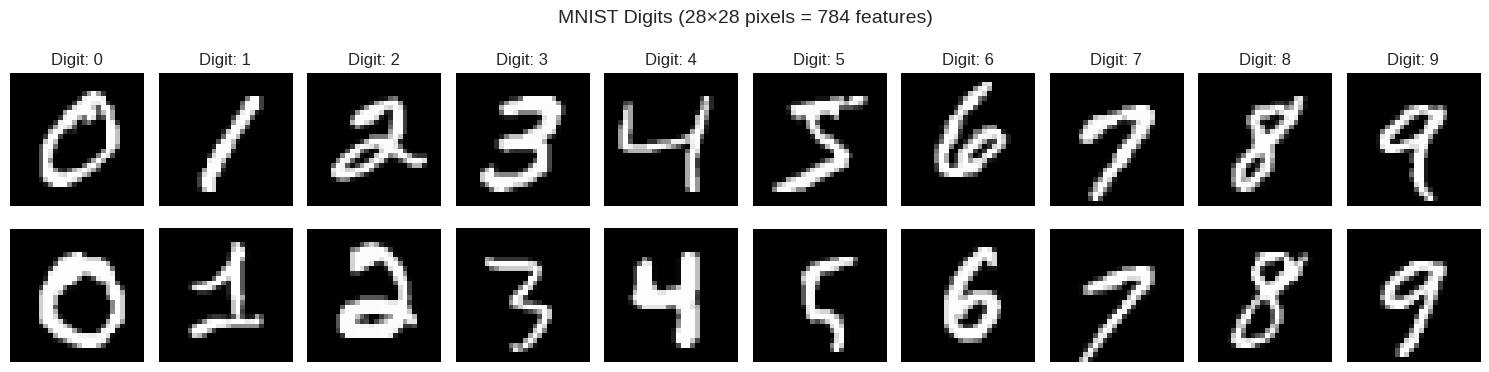

In [3]:
# Visualize some digits
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    # Find first instance of each digit
    idx = np.where(y == i)[0][0]

    # First row: the digit
    axes[0, i].imshow(x[idx].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f'Digit: {i}')
    axes[0, i].axis('off')

    # Second row: another instance
    idx2 = np.where(y == i)[0][5]
    axes[1, i].imshow(x[idx2].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')

plt.suptitle('MNIST Digits (28×28 pixels = 784 features)', fontsize=14)
plt.tight_layout()
plt.show()

In [4]:
#using a subset from the df
n_samples = 10000


np.random.seed(42)
indices = np.random.choice(len(x), n_samples, replace=False)

x_subset = x[indices]
y_subset = y[indices]

print(f"Using {n_samples:,} samples for dimensionality reduction")
print(f"Classs distribution:")
for digit in range(10):
  count = (y_subset == digit).sum()
  print(f"Digit {digit}: {count:,}")

Using 10,000 samples for dimensionality reduction
Classs distribution:
Digit 0: 983
Digit 1: 1,152
Digit 2: 967
Digit 3: 1,034
Digit 4: 906
Digit 5: 937
Digit 6: 961
Digit 7: 1,055
Digit 8: 969
Digit 9: 1,036


In [5]:
#Scaling the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_subset)

print(f"Data scaled: mean={x_scaled.mean():.4f}, std={x_scaled.std():.4f}")

Data scaled: mean=0.0000, std=0.9347


The challenge is visualizing 784 dimensions


##PCA (Principal Component Analysis)

**Idea:** Find directions (principal components) that capture the most variance.

**Key Points:**
- Linear transformation
- Fast
- Components are orthogonal
- Good for preprocessing, okay for visualization

In [10]:
#The solution would be to reduce it to 2-3 dimensions
start = time()

pca_2d = PCA(n_components=2, random_state=42)
x_pca_2d = pca_2d.fit_transform(x_scaled)

pca_time = time() - start
print(f"PCA completed in {pca_time:.2f} seconds")
print(f"Explained variance: {pca_2d.explained_variance_ratio_}")

PCA completed in 0.51 seconds
Explained variance: [0.05947163 0.04292622]


/tmp/ipython-input-2737592012.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=str(i), s=50) for i in range(10)]


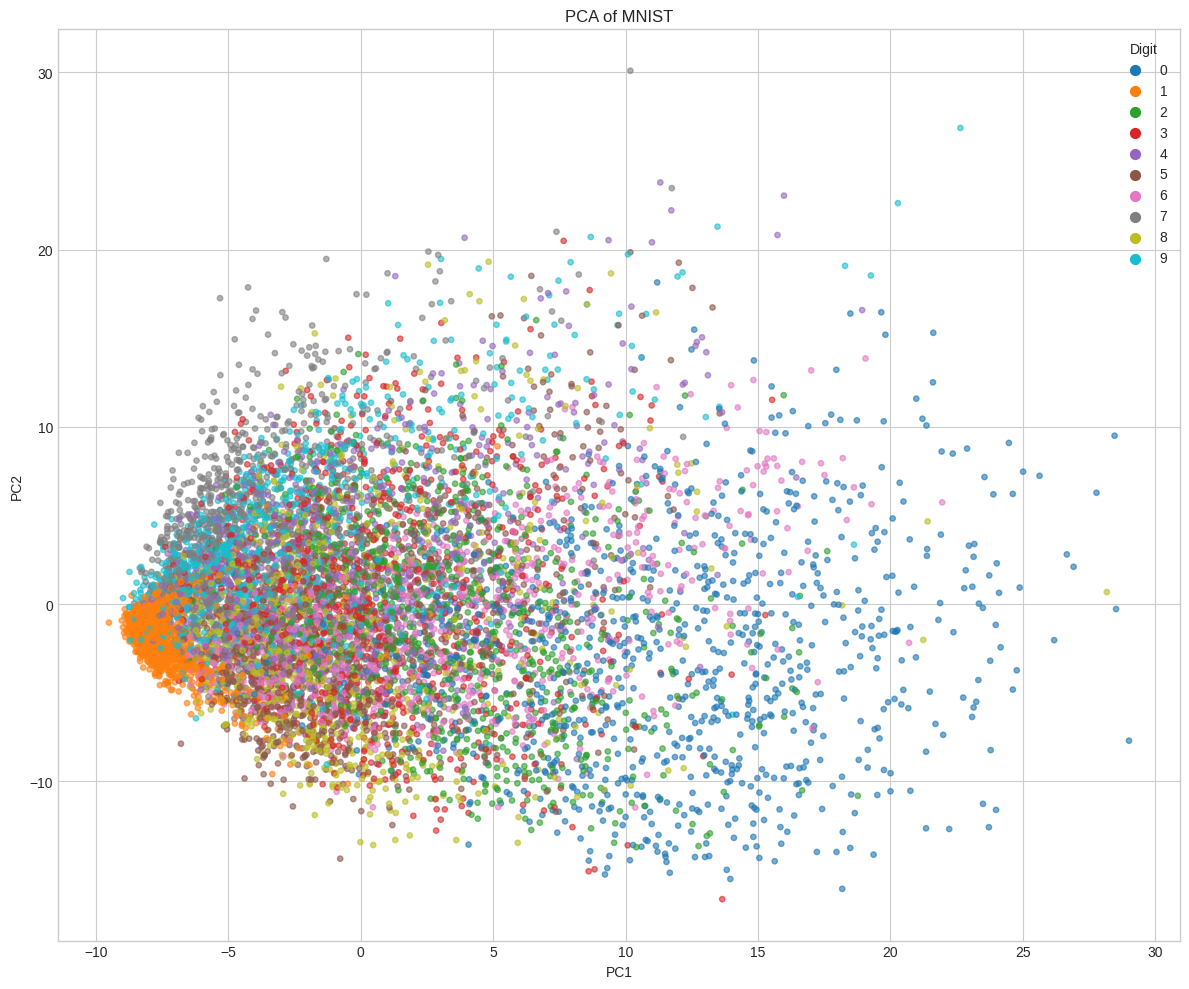

In [11]:
#Visualiing PCA results
fig, ax = plt.subplots(figsize=(12, 10))

scatter  = ax.scatter(x_pca_2d[:, 0], x_pca_2d[:, 1],
                      c = y_subset, cmap='tab10', alpha=0.6, s=15)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA of MNIST')

handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=str(i), s=50) for i in range(10)]
ax.legend(handles=handles, title='Digit', loc='upper right')

plt.tight_layout()
plt.show()

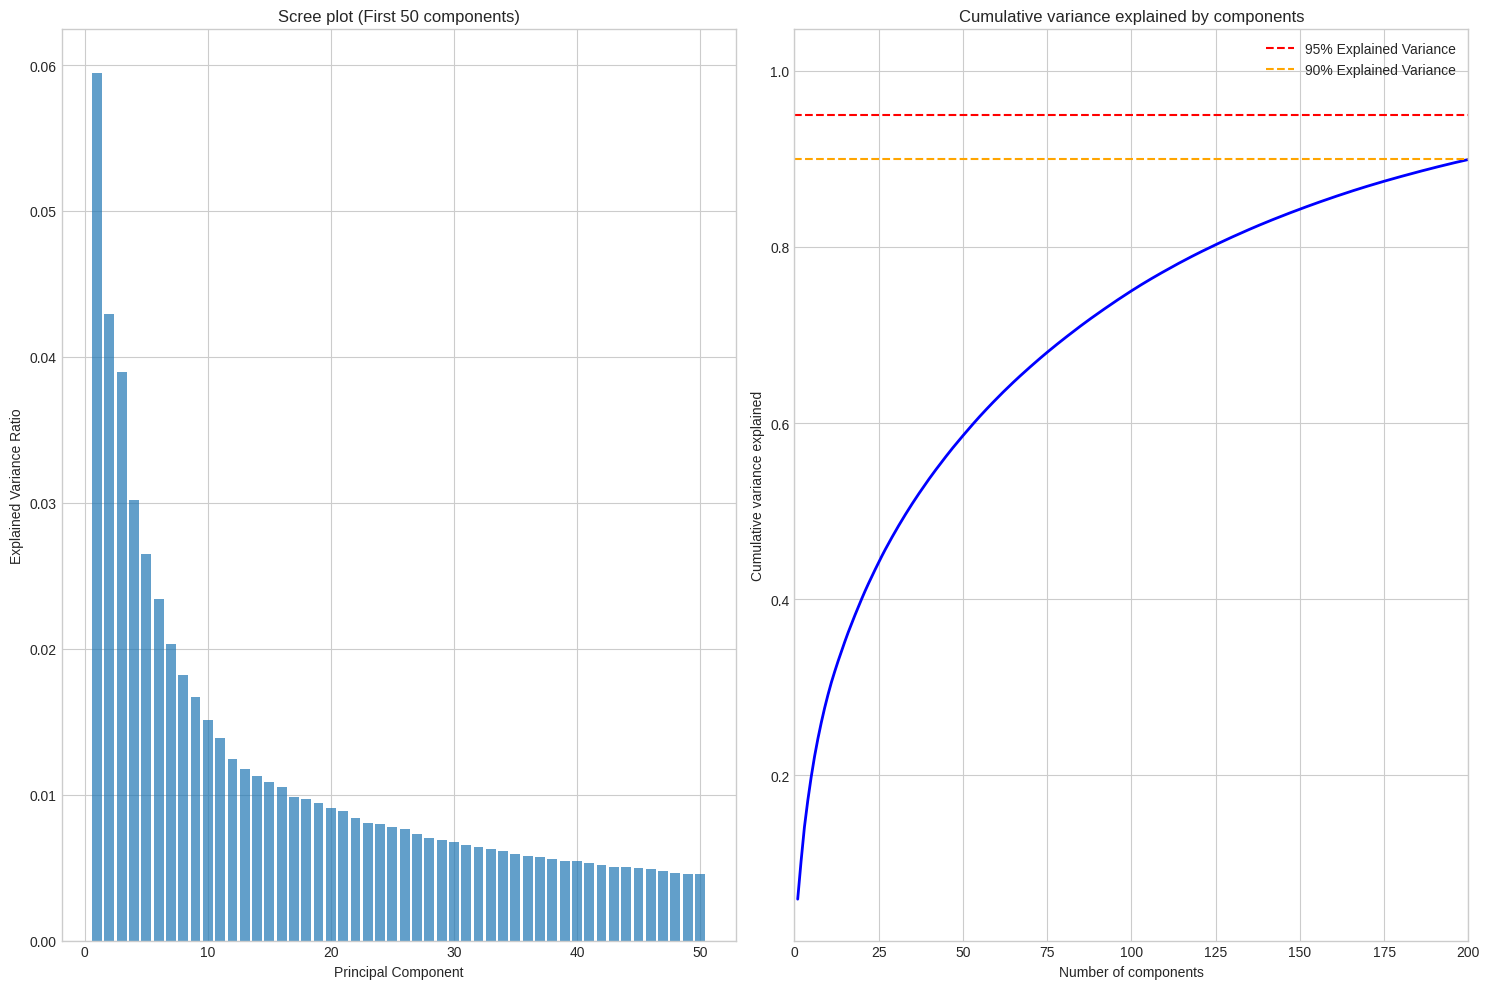

In [19]:
#How many components do we need
pca_full = PCA(random_state=42)
pca_full.fit(x_scaled)

#cummulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
fig, axes = plt.subplots(1, 2, figsize=(15, 10))

#Scree plot
axes[0].bar(range(1, 51), pca_full.explained_variance_ratio_[:50], alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree plot (First 50 components)')

#Cumulative variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'b-', linewidth=2)
axes[1].axhline(y=0.95,color='r', linestyle='--', label='95% Explained Variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% Explained Variance')

#Finding the no. of components for thresholds
n_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_95 = np.argmax(cumulative_variance >= 0.95) + 1

axes[1].axvline(x=n_90, color='orange', linestyle=':', alpha=0.7)
axes[1].axvline(x=n_95, color='r', linestyle=':', alpha=0.7)

axes[1].set_xlabel("Number of components")
axes[1].set_ylabel("Cumulative variance explained")
axes[1].set_title("Cumulative variance explained by components")
axes[1].legend()
axes[1].set_xlim(0, 200)

plt.tight_layout()
plt.show()



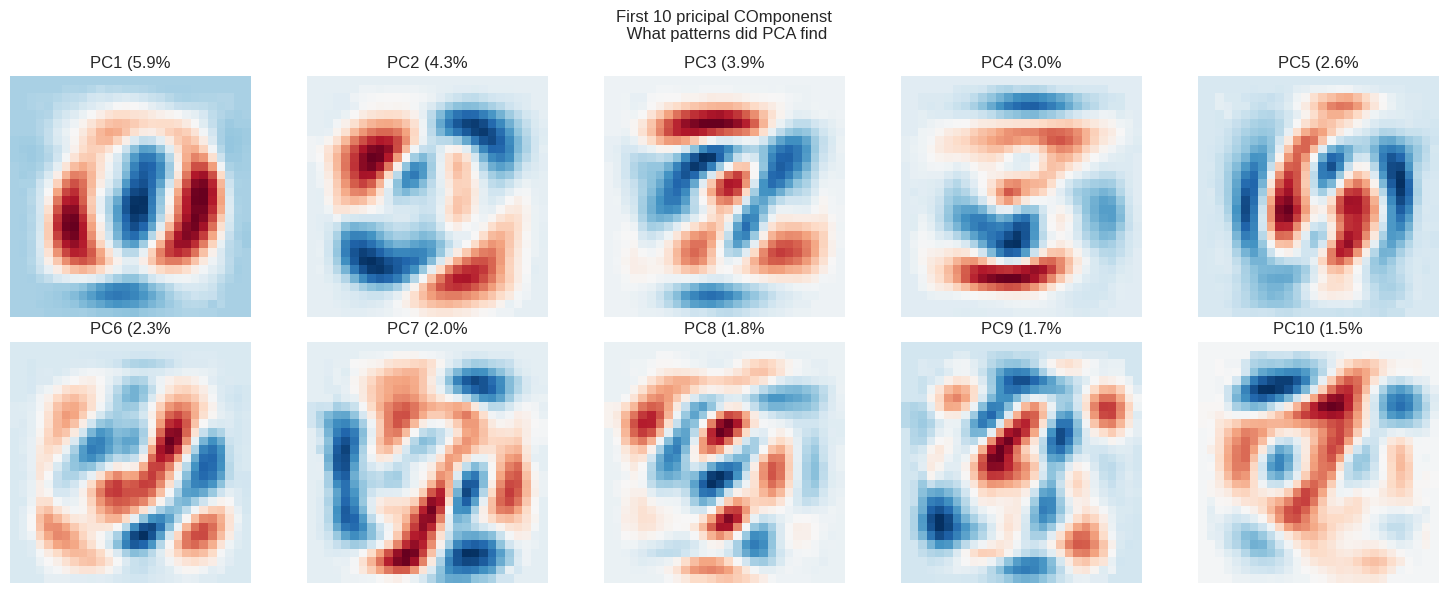

In [21]:
#
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
  #Each component is a 784-dim vector so we will flatten it tp 28 x 28
  component = pca_full.components_[i].reshape(28, 28)
  im = ax.imshow(component, cmap='RdBu_r')
  ax.set_title(f'PC{i+1} ({pca_full.explained_variance_ratio_[i]:.1%}')
  ax.axis('off')

plt.suptitle('First 10 pricipal COmponenst\n What patterns did PCA find')
plt.tight_layout()
plt.show()


---
##t-SNE (t-Distributed Stochastic Neighbor Embedding)

**Idea:** Preserve local neighborhoods — similar points stay close.

**Key Points:**
- Non-linear
- Excellent for visualization
- Slow on large datasets
- Not for preprocessing (no transform for new data)

In [22]:
#first reduce with PCA (speeds up t-SNE)
pca_50 = PCA(n_components=50, random_state=42)
x_pca_50= pca_50.fit_transform(x_scaled)

print(f"Variance Retained: {pca_50.explained_variance_ratio_.sum():.1%}")

Variance Retained: 58.6%


In [24]:
#t-SNE
start = time()

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
x_tsne = tsne.fit_transform(x_pca_50)

tsne_time = time() - start
print(f"t-SNE completed in {tsne_time:.2f} seconds")

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE completed in 123.25 seconds


/tmp/ipython-input-2924735137.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=str(i), s=50) for i in range(10)]


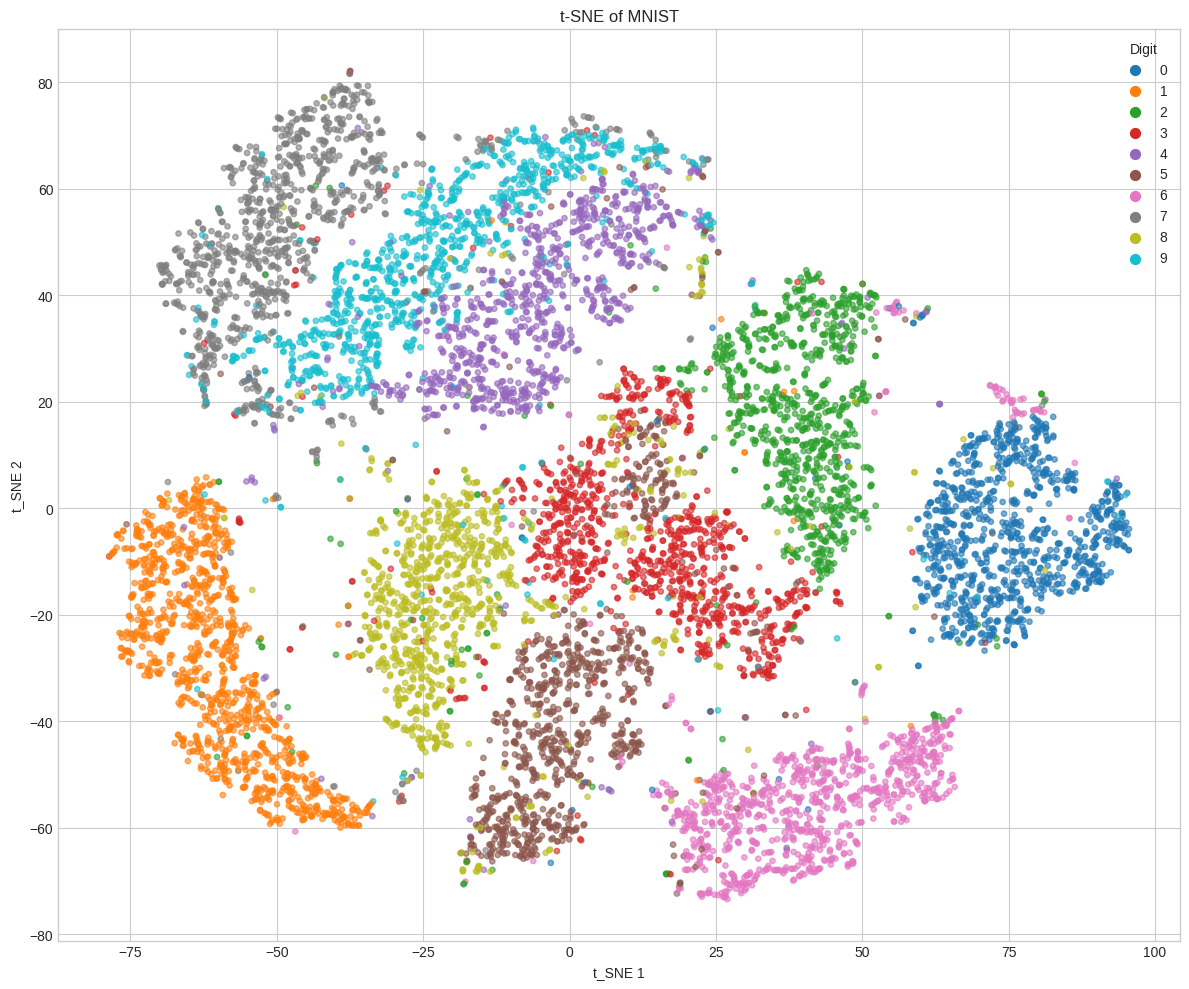

In [27]:
#Visualizing the t-SNE results
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_subset,
                     cmap='tab10', alpha=0.6, s=15)
ax.set_xlabel('t_SNE 1')
ax.set_ylabel('t_SNE 2')
ax.set_title('t-SNE of MNIST')

handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=str(i), s=50) for i in range(10)]
ax.legend(handles=handles, title='Digit', loc='upper right')

plt.tight_layout()
plt.show()

We can observe that the clusters for similar digts (4 & 9, 3 & 5) are closer, hence it provides a much better separation than PCA

Running t-SNE with perplexity=5...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE with perplexity=30...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Running t-SNE with perplexity=100...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


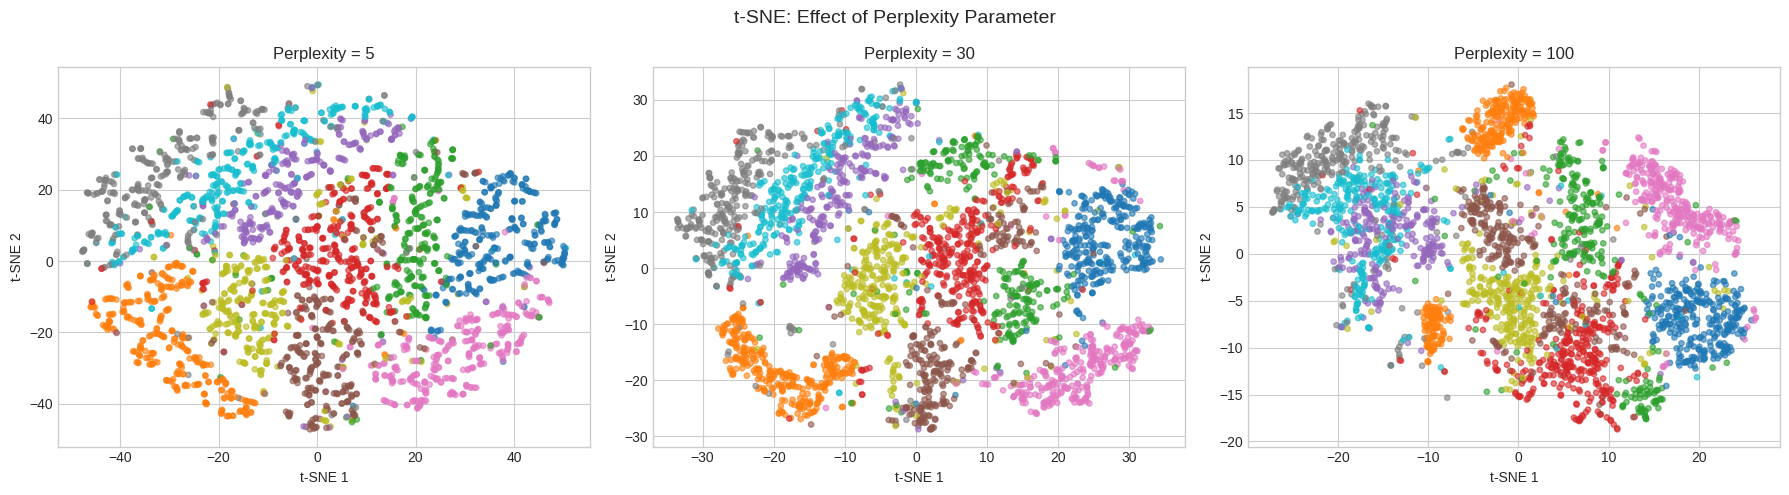

In [30]:
# Effect of perplexity parameter
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

perplexities = [5, 30, 100]

for ax, perp in zip(axes, perplexities):
    print(f"Running t-SNE with perplexity={perp}...")
    tsne_temp = TSNE(n_components=2, perplexity=perp, random_state=42, n_iter=500)
    x_temp = tsne_temp.fit_transform(x_pca_50[:3000])  # Use smaller subset for speed

    scatter = ax.scatter(x_temp[:, 0], x_temp[:, 1],
                         c=y_subset[:3000], cmap='tab10', alpha=0.6, s=15)
    ax.set_title(f'Perplexity = {perp}')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')

plt.suptitle('t-SNE: Effect of Perplexity Parameter', fontsize=14)
plt.tight_layout()
plt.show()

---
##UMAP (Uniform Manifold Approximation and Projection)

**Idea:** Similar to t-SNE but faster and preserves more global structure.

**Key Points:**
- Non-linear
- Faster than t-SNE
- Better global structure preservation
- Can transform new data

In [32]:
import umap

#UMAP

start = time()

umap_reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=42)
x_umap = umap_reducer.fit_transform(x_pca_50)

umap_time = time() - start
print(f"UMAP completed in {umap_time:.2f} seconds")

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP completed in 46.51 seconds


/tmp/ipython-input-3060379316.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=str(i), s=50) for i in range(10)]


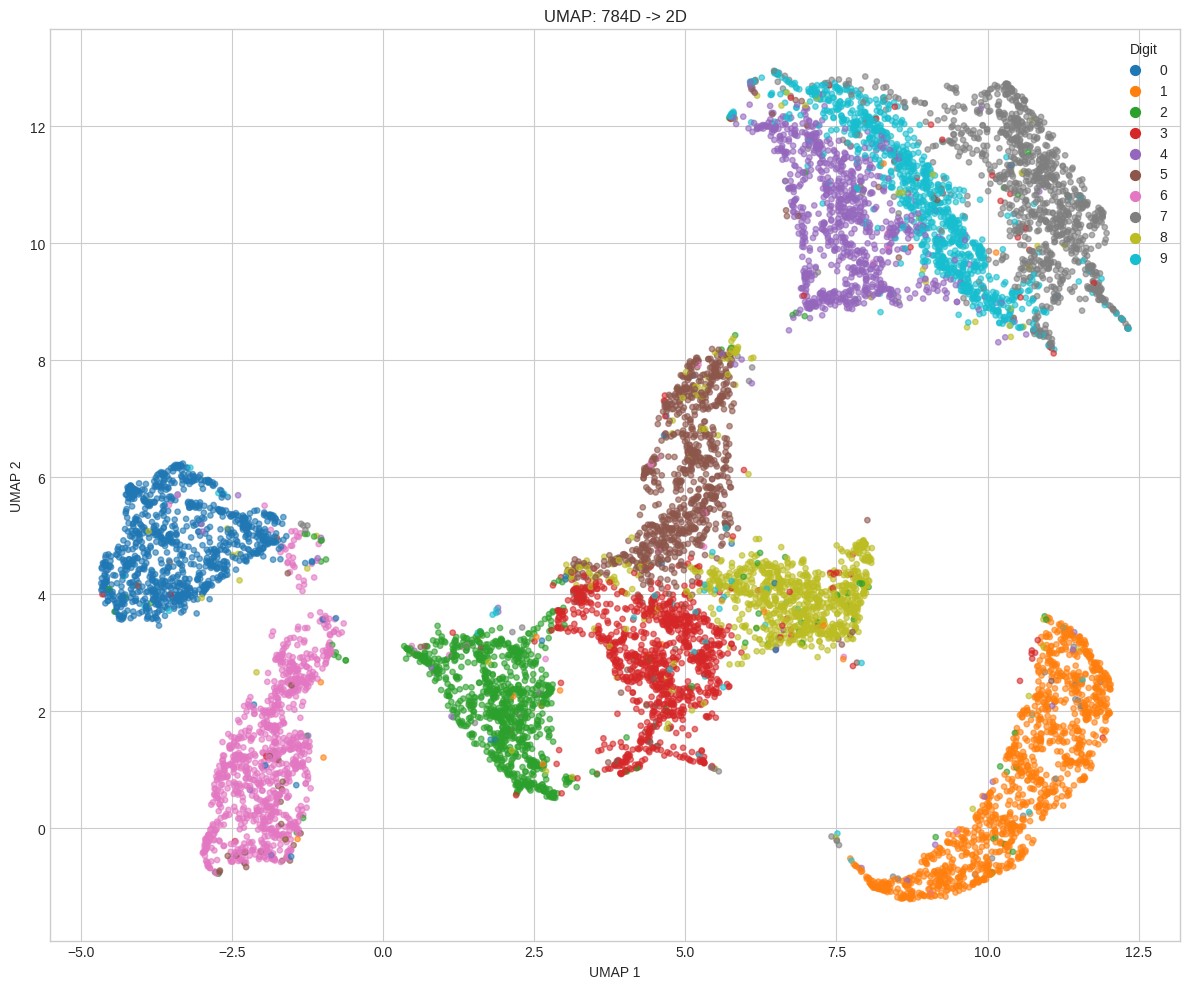

In [34]:
#Visualizing the UMAP results
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(x_umap[:, 0], x_umap[:, 1], c=y_subset, cmap='tab10', alpha=0.6, s=15)
ax.set_xlabel('UMAP 1')
ax.set_ylabel("UMAP 2")
ax.set_title("UMAP: 784D -> 2D")

handles = [plt.scatter([], [], c=plt.cm.tab10(i/10), label=str(i), s=50) for i in range(10)]
ax.legend(handles=handles, title='Digit', loc='upper right')

plt.tight_layout()
plt.show()

Running UMAP with n_neighbors=5...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with n_neighbors=15...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with n_neighbors=50...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.0...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.1...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Running UMAP with min_dist=0.5...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


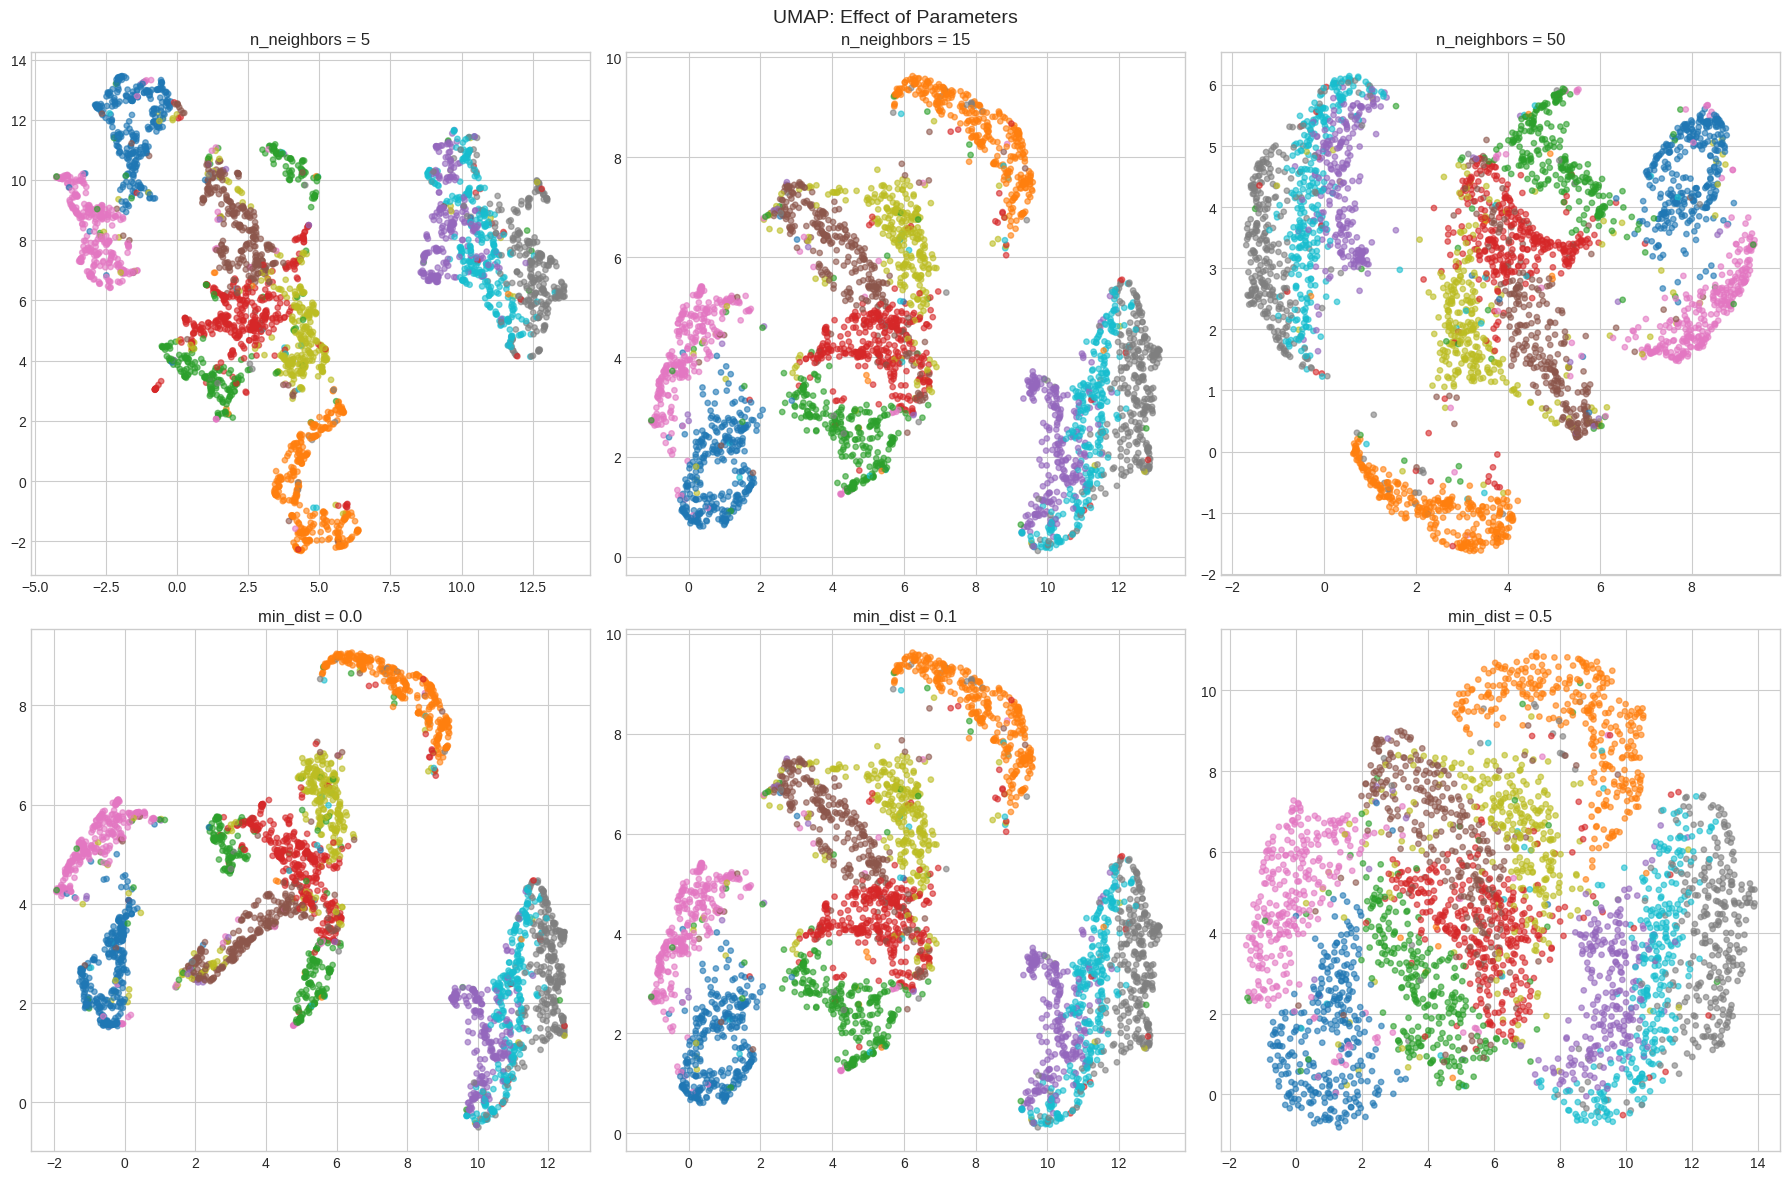

In [39]:
# Effect of UMAP parameters
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Vary n_neighbors
n_neighbors_list = [5, 15, 50]
for ax, nn in zip(axes[0], n_neighbors_list):
    print(f"Running UMAP with n_neighbors={nn}...")
    reducer = umap.UMAP(n_components=2, n_neighbors=nn, min_dist=0.1, random_state=42)
    x_temp = reducer.fit_transform(x_pca_50[:3000])

    ax.scatter(x_temp[:, 0], x_temp[:, 1], c=y_subset[:3000], cmap='tab10', alpha=0.6, s=15)
    ax.set_title(f'n_neighbors = {nn}')

# Vary min_dist
min_dist_list = [0.0, 0.1, 0.5]
for ax, md in zip(axes[1], min_dist_list):
    print(f"Running UMAP with min_dist={md}...")
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=md, random_state=42)
    x_temp = reducer.fit_transform(x_pca_50[:3000])

    ax.scatter(x_temp[:, 0], x_temp[:, 1], c=y_subset[:3000], cmap='tab10', alpha=0.6, s=15)
    ax.set_title(f'min_dist = {md}')

plt.suptitle('UMAP: Effect of Parameters', fontsize=14)
plt.tight_layout()
plt.show()

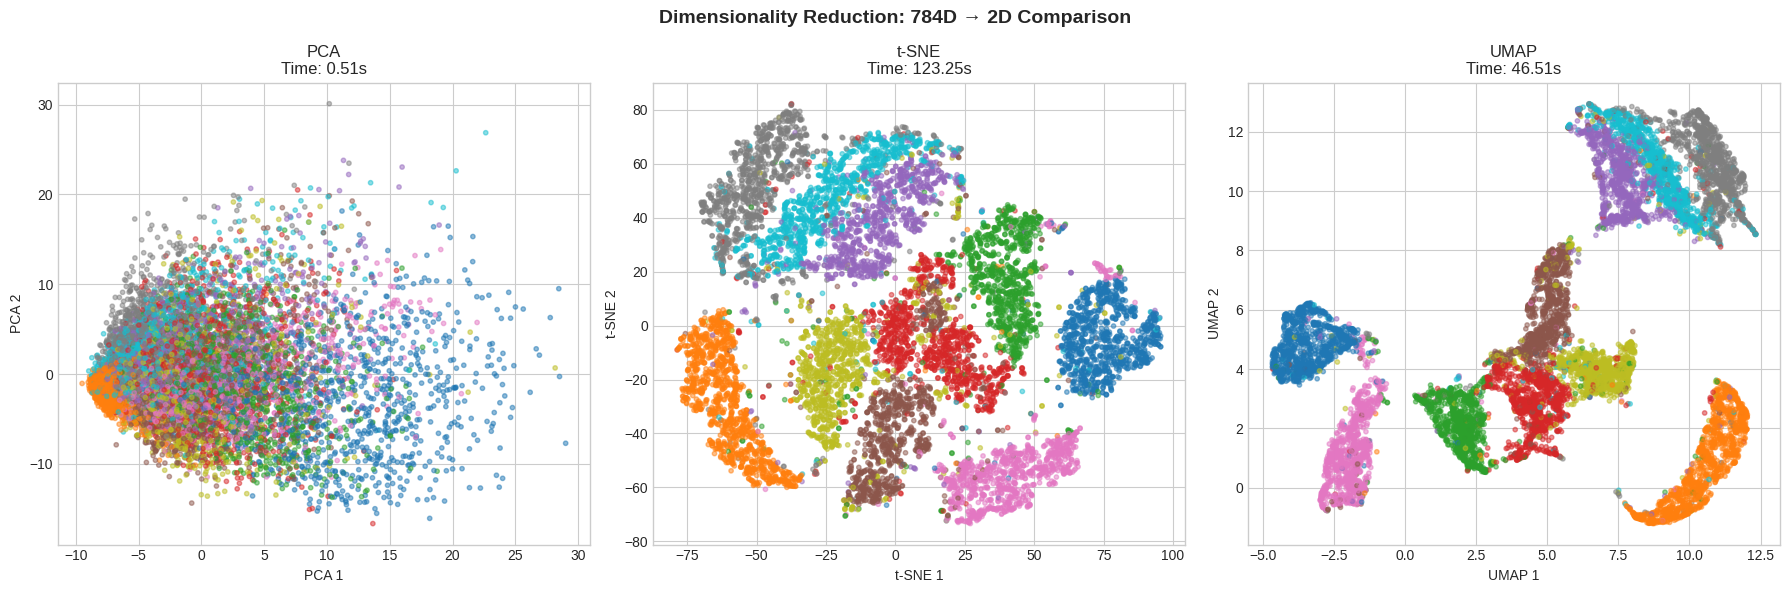

In [37]:
# Compare all three methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = [
    ('PCA', x_pca_2d, pca_time),
    ('t-SNE', x_tsne, tsne_time),
    ('UMAP', x_umap, umap_time)
]

for ax, (name, x_reduced, reduction_time) in zip(axes, methods):
    scatter = ax.scatter(x_reduced[:, 0], x_reduced[:, 1],
                         c=y_subset, cmap='tab10', alpha=0.5, s=10)
    ax.set_title(f'{name}\nTime: {reduction_time:.2f}s')
    ax.set_xlabel(f'{name} 1')
    ax.set_ylabel(f'{name} 2')

plt.suptitle('Dimensionality Reduction: 784D → 2D Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [40]:
# Quantitative comparison: How well do clusters separate?
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

print("Evaluating cluster quality using k-NN accuracy:")
print("="*50)

results = []

for name, x_reduced, reduction_time in methods:
    knn = KNeighborsClassifier(n_neighbors=5)
    scores = cross_val_score(knn, x_reduced, y_subset, cv=5)

    result = {
        'Method': name,
        'Time (s)': reduction_time,
        'k-NN Accuracy': scores.mean(),
        'Std': scores.std()
    }
    results.append(result)
    print(f"{name}: {scores.mean():.1%} (±{scores.std():.1%})")

results_df = pd.DataFrame(results)
print(f"\n{results_df.to_string(index=False)}")

Evaluating cluster quality using k-NN accuracy:
PCA: 33.5% (±0.9%)
t-SNE: 91.9% (±0.5%)
UMAP: 91.1% (±0.7%)

Method   Time (s)  k-NN Accuracy      Std
   PCA   0.509735         0.3353 0.008693
 t-SNE 123.254589         0.9191 0.005238
  UMAP  46.514824         0.9111 0.007290


Running 3D UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


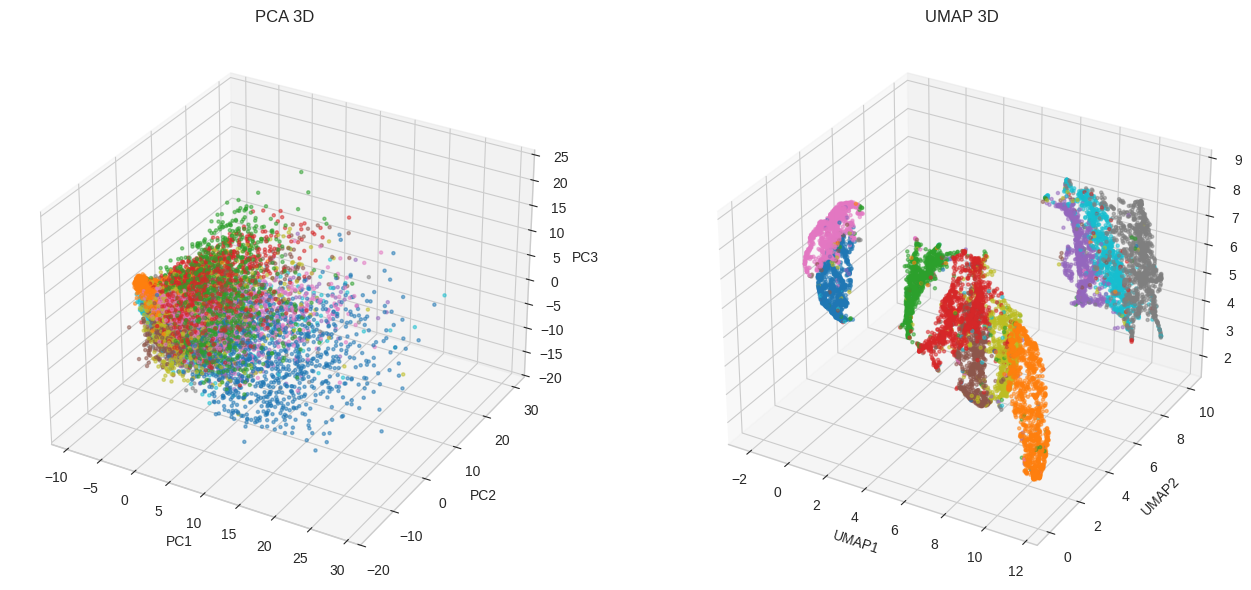

In [41]:
# 3D PCA
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3, random_state=42)
x_pca_3d = pca_3d.fit_transform(x_scaled)

fig = plt.figure(figsize=(14, 6))

# PCA 3D
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(x_pca_3d[:, 0], x_pca_3d[:, 1], x_pca_3d[:, 2],
                       c=y_subset, cmap='tab10', alpha=0.5, s=5)
ax1.set_title('PCA 3D')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')

# UMAP 3D
print("Running 3D UMAP...")
umap_3d = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
x_umap_3d = umap_3d.fit_transform(x_pca_50)

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(x_umap_3d[:, 0], x_umap_3d[:, 1], x_umap_3d[:, 2],
                       c=y_subset, cmap='tab10', alpha=0.5, s=5)
ax2.set_title('UMAP 3D')
ax2.set_xlabel('UMAP1')
ax2.set_ylabel('UMAP2')
ax2.set_zlabel('UMAP3')

plt.tight_layout()
plt.show()

---
## Key Takeaways

### The Three Methods:

| Method | When to Use |
|--------|-------------|
| **PCA** | Preprocessing, noise reduction, fast visualization |
| **t-SNE** | Best visualization quality, don't need to transform new data |
| **UMAP** | Good visualization + can transform new data, faster than t-SNE |

### Key Insights:

1. **PCA** finds directions of maximum variance (linear)
2. **t-SNE** preserves local neighborhoods (non-linear)
3. **UMAP** balances local and global structure (non-linear)
4. **Combine them**: PCA first (speed up), then t-SNE/UMAP

### MNIST Results:

- 784 pixels → 2D visualization
- PCA: Fast but clusters overlap
- t-SNE/UMAP: Clear digit clusters
- 100 PCA components retain ~92% accuracy (vs 784)
